# Validating and Importing Target Time Series Data

## Obtaining Your Data

A critical requirement to use Amazon Forecast is to have access to time-series data for your selected use case. To learn more about time series data:

1. [Wikipedia](https://en.wikipedia.org/wiki/Time_series)
1. [Toward's Data Science Primer](https://towardsdatascience.com/the-complete-guide-to-time-series-analysis-and-forecasting-70d476bfe775)
1. [O'Reilly Book](https://www.amazon.com/gp/product/1492041653/ref=ppx_yo_dt_b_search_asin_title?ie=UTF8&psc=1)

As an exmaple for this POC guide we are going to select a dataset from the UCI repository of machine learning datasets. This is a great tool for finding datasets for various problems. In this particular case it is traffic data for a given section of interstate highway. More information on the dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume)

Your specific data my come from a DB export, an existing spreadsheet, it really does not matter the source. Going forward the files should be uploaded into this notebook and stored in CSV format.

To begin the cell below will complete the following:

1. Create a directory for the data files.
1. Download the sample data into the directory.
1. Extract the archive file into the directory.

In [1]:
data_dir = "data"
!mkdir $data_dir
!cd $data_dir && wget http://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz
!cd $data_dir && gunzip Metro_Interstate_Traffic_Volume.csv.gz

--2020-06-02 14:21:30--  http://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 405373 (396K) [application/x-httpd-php]
Saving to: ‘Metro_Interstate_Traffic_Volume.csv.gz’

Metro_Interstate_Tr 100%[===================>] 395.87K   838KB/s    in 0.5s    

2020-06-02 14:21:30 (838 KB/s) - ‘Metro_Interstate_Traffic_Volume.csv.gz’ saved [405373/405373]



With the data downloaded, now we will import the Pandas library as well as a few other data science tools in order to inspect the information.

In [2]:
import boto3
from time import sleep
import subprocess
import pandas as pd
import json
import time
import pprint
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

Next open the file with Pandas and take a look at the contents

In [3]:
original_data = pd.read_csv(data_dir + '/Metro_Interstate_Traffic_Volume.csv')
original_data.head(5)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


At this point we can see a few things about the data:

* Holidays seem to be specified
* There is a value for temp, rainfall, snowfall, and a few other weather metrics.
* The time series is hourly
* Our value to predict is `traffic_volume down` at the end.

Amazon Forecast relies on a concept called the target-time-series in order to start making predictions, this has a timestamp, an item identifier, and a value. The timestamp is pretty self explanatory, and the value to predict will be traffic_volume, given this is a singular time series an arbitrary item_ID of `1` will be applied later to all entries in the time series file.

The other attributes provided can serve as a basis for related time series components when we get to that much later.

Amazon Forecast also works well to fill in gaps for the target-time-series but not the related data, so before we input our data and get a prediction we should look to see where gaps are, and how we want to structure both inputs to address this issue. 

To get started we will manipulate our starting dataframe to determine the quality and consistency of this dataset.

Start Date:  2012-10-02 09:00:00
End Date:  2018-09-30 23:00:00


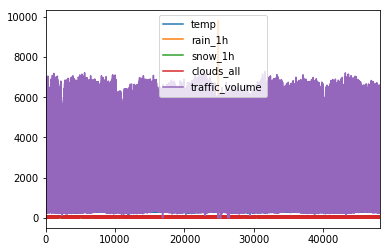

In [4]:
target_df = original_data.copy()
target_df.plot()
print("Start Date: ", min(target_df['date_time']))
print("End Date: ", max(target_df['date_time']))

Interestingly at this point we do not see an obvious gaps in this plot, but we should still check a bit deeper to confirm this. The next cell gives some basic information on the dataset size.

In [5]:
target_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
holiday                48204 non-null object
temp                   48204 non-null float64
rain_1h                48204 non-null float64
snow_1h                48204 non-null float64
clouds_all             48204 non-null int64
weather_main           48204 non-null object
weather_description    48204 non-null object
date_time              48204 non-null object
traffic_volume         48204 non-null int64
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


In the cell above we now see a range of October 2012 to nearly October 2018, almost 6 years of hourly data. Given there are around 8700 hours in a year we expect to see 52,000 time series. Immediately here we see 48,204. It looks like some data points are missing, next let us define the index, drop the duplicates and see where we are then.

In [6]:
target_df.set_index('date_time', inplace=True)
#target_df = target_df.drop_duplicates(keep ='first')
target_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48204 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Data columns (total 8 columns):
holiday                48204 non-null object
temp                   48204 non-null float64
rain_1h                48204 non-null float64
snow_1h                48204 non-null float64
clouds_all             48204 non-null int64
weather_main           48204 non-null object
weather_description    48204 non-null object
traffic_volume         48204 non-null int64
dtypes: float64(3), int64(2), object(3)
memory usage: 3.3+ MB


That change dropped us to 48,204 unique entries. Given this is traffic data we could be dealing with a missing sensor, construction causing outages, or even severe weather delay damaging the recording equipment. Before we decide on how to fill any gaps, let us first take a look to see where they are, and how large the gaps themselves may be.

We will do this by creating a new dataframe for the entire length of the dataset, that has no missing entries, then joining our data to it, and padding out 0's where anything is missing.

*Note* the periods value below is the total number of entriess to make, I cheated and used WolframAlpha to sort out the number of days: https://www.wolframalpha.com/input/?i=days+from+2012-10-02+to+2018-09-30

In [7]:
total_days = 2190
# Build the index first
idx = pd.date_range(start='10/02/2012', end='09/30/2018', freq='H')

In [8]:
full_df = pd.DataFrame(index=idx)
full_df.head(3)

""
2012-10-02 00:00:00
2012-10-02 01:00:00
2012-10-02 02:00:00


In [9]:
print (full_df.index.min())
print (full_df.index.max())

2012-10-02 00:00:00
2018-09-30 00:00:00


In [10]:
# Now perform the join
full_historical_df = full_df.join(target_df, how='outer')
print (full_historical_df.index.min())
print (full_historical_df.index.max())

2012-10-02 00:00:00
2018-09-30 23:00:00


In [11]:
# Take a look at 10 random entries
full_historical_df.sample(10)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
2018-05-07 10:00:00,None,294.54,0.00,0.0,5.0,Clear,sky is clear,4369.0
2018-01-03 03:00:00,None,258.72,0.00,0.0,40.0,Clouds,scattered clouds,358.0
2013-03-11 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-09-17 17:00:00,None,295.35,0.25,0.0,75.0,Rain,moderate rain,6223.0
2018-09-11 20:00:00,None,297.74,0.00,0.0,75.0,Clouds,broken clouds,3114.0
2013-03-12 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-20 10:00:00,None,264.08,0.00,0.0,90.0,Haze,haze,4402.0
2017-05-21 16:00:00,None,282.46,0.00,0.0,90.0,Rain,light rain,4718.0
2016-08-24 19:00:00,None,295.26,0.00,0.0,90.0,Clouds,overcast clouds,3356.0
2018-03-26 23:00:00,None,274.15,0.00,0.0,90.0,Rain,moderate rain,877.0


The sample may or may not have shown values with NaNs or other nulls, in this instance it did but we will still want to look for these NaN entities to confirm if they exist and where they are.

At this point we have done enough work to see where we may have any large portions of missing data. To that end we can plot the data below and see any gaps that may crop up.

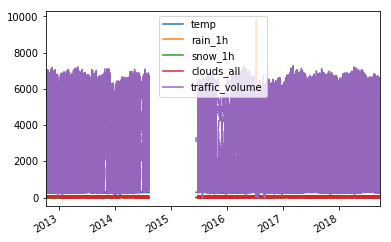

In [12]:
full_historical_df.plot()

This shows a large gap of missing data from late 2014 until mid 2016. If we just wanted to feed in the previously known value this may give us too long of a timeframe of data that is simply not relexive to the problem. 

Before making any decisions we will now step through each year and see what the gaps look like starting in 2013 as it is the first full year.

2017-01-01 00:00:00
2017-12-31 23:00:00


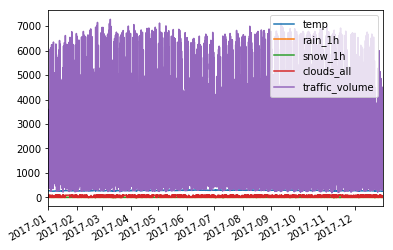

In [13]:
df_2017 = full_historical_df.loc['2017-01-01':'2017-12-31']
print (df_2017.index.min())
print (df_2017.index.max())
df_2017.plot()

2018-01-01 00:00:00
2018-09-30 23:00:00


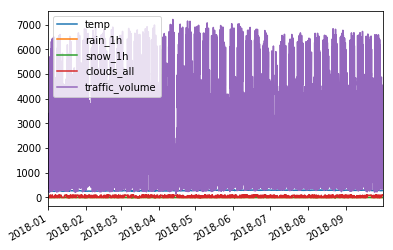

In [14]:
df_2018 = full_historical_df.loc['2018-01-01':'2018-12-31']
print (df_2018.index.min())
print (df_2018.index.max())
df_2018.plot()

A few things to note here, clearly we are missing a large volume of data in 2014 and 2015 but also there are some missing patches in 2013 as well. 2016 had spotty data initially but 2017 and 2018 look pretty good.

Given that the data is hourly we still have plenty of it within a single year, and an additional 10 months to use for broader validation if we choose to do that. 

To note, it seems approaches like DeepAR+ and Prophet work very well with > 1k measurements on a given time series. Assuming hourly data (24 measurements per day), that yields around 42 days before we have a solid base of data. Learning over an entire year should be plenty.

Also we need to think about a Forecast horizon or how far into the future we are going to predict at once. Forecast currently limits us to 500 intervals of whatever granularity we have selected. For this exercise we will keep the data hourly and predict 480 hours into the future, or exactly 20 days.

## Building Data Files

Knowing that our above dataframe `full_historical_df` covers the entire time period we care about we start there reducing it to 2017 to end. Then we will use feed forward to plug in any missing holes before splitting into the 3 files described before. 

More info on techniques to patch missing information can be found here: https://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.DataFrame.fillna.html 

The risk of filling in values like this is that in smoothing out the data it may cause our predictions to resemble the smoother curve than is our historical data. This is why we selected 2017 to 2018 based on the lack of large gaps in the data.

In [15]:
# Create a copy
target_df = full_historical_df.copy()
# Slice to only 2017 onward
target_df = target_df.loc['2017-01-01':]
# Validate the dates
print (target_df.index.min())
print (target_df.index.max())

2017-01-01 00:00:00
2018-09-30 23:00:00


In [16]:
# Fill in any missing data with the method ffill
target_df.ffill()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
2017-01-01 00:00:00,None,269.75,0.00,0.0,75.0,Clouds,broken clouds,1848.0
2017-01-01 01:00:00,None,269.95,0.00,0.0,1.0,Clear,sky is clear,1806.0
2017-01-01 02:00:00,None,269.75,0.00,0.0,1.0,Clear,sky is clear,1211.0
2017-01-01 03:00:00,None,269.65,0.00,0.0,40.0,Clouds,scattered clouds,794.0
2017-01-01 04:00:00,None,269.48,0.00,0.0,1.0,Clear,sky is clear,500.0
2017-01-01 05:00:00,None,269.22,0.00,0.0,1.0,Clear,sky is clear,513.0
2017-01-01 06:00:00,None,268.90,0.00,0.0,1.0,Clear,sky is clear,821.0
2017-01-01 07:00:00,None,268.34,0.00,0.0,40.0,Clouds,scattered clouds,950.0
2017-01-01 08:00:00,None,267.90,0.00,0.0,1.0,Clear,sky is clear,1284.0
2017-01-01 09:00:00,None,267.71,0.00,0.0,20.0,Clouds,few clouds,2279.0


At this point we have all the data needed to make our target time series file and dataset. While we are doing this we will also make a validation file for later use as well.

In [17]:
# Take a look at 10 random entries
target_df.sample(10)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
2018-04-23 00:00:00,None,278.910,0.00,0.0,1.0,Clear,sky is clear,614.0
2017-10-06 17:00:00,None,286.440,0.00,0.0,90.0,Drizzle,light intensity drizzle,5655.0
2018-09-18 05:00:00,None,288.210,3.18,0.0,20.0,Mist,mist,3027.0
2017-05-29 12:00:00,None,287.350,0.00,0.0,90.0,Drizzle,light intensity drizzle,3504.0
2017-07-22 07:00:00,None,293.550,0.00,0.0,1.0,Clear,sky is clear,1996.0
2018-09-17 03:00:00,None,295.830,0.00,0.0,75.0,Clouds,broken clouds,344.0
2017-10-12 05:00:00,None,285.500,0.00,0.0,90.0,Drizzle,drizzle,2982.0
2017-08-09 14:00:00,None,291.310,0.00,0.0,90.0,Rain,moderate rain,4975.0
2017-02-14 17:00:00,None,271.087,0.00,0.0,0.0,Clear,Sky is Clear,6093.0
2018-06-02 16:00:00,None,290.580,0.00,0.0,90.0,Mist,mist,4560.0


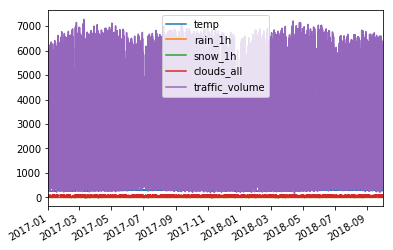

In [18]:
target_df.plot()

### Building The Target Time Series File

In [19]:
target_time_series_df = target_df.copy()
target_time_series_df = target_time_series_df.loc['2017-01-01':'2017-12-31']
# Validate the date range
print (target_time_series_df.index.min())
print (target_time_series_df.index.max())

2017-01-01 00:00:00
2017-12-31 23:00:00


In [20]:
# Restrict the columns to timestamp, traffic_volume
target_time_series_df = target_time_series_df[['traffic_volume']]
# Add in item_id
target_time_series_df['item_ID'] = "1"
# Validate the structure
target_time_series_df.head()

,traffic_volume,item_ID
2017-01-01 00:00:00,1848.0,1
2017-01-01 01:00:00,1806.0,1
2017-01-01 02:00:00,1211.0,1
2017-01-01 03:00:00,794.0,1
2017-01-01 04:00:00,500.0,1


In [21]:
# With the data in a great state, save it off as a CSV
target_time_series_filename = "target_time_series.csv"
target_time_series_path = data_dir + "/" + target_time_series_filename
target_time_series_df.to_csv(target_time_series_path, header=False)

### Building The Validation File

This is the last file we need to build before getting started with Forecast itself. This will be the same in structure as our target-time-series file but will only project into 2018 and includes no historical data from the training data.

In [22]:
validation_time_series_df = target_df.copy()
validation_time_series_df = validation_time_series_df.loc['2018-01-01':]
# Validate the date range
print (validation_time_series_df.index.min())
print (validation_time_series_df.index.max())

2018-01-01 00:00:00
2018-09-30 23:00:00


In [23]:
# Restrict the columns to timestamp, traffic_volume
validation_time_series_df = validation_time_series_df[['traffic_volume']]
# Add in item_id
validation_time_series_df['item_ID'] = "1"
# Validate the structure
validation_time_series_df.head()

,traffic_volume,item_ID
2018-01-01 00:00:00,1478.0,1
2018-01-01 01:00:00,1408.0,1
2018-01-01 02:00:00,931.0,1
2018-01-01 03:00:00,585.0,1
2018-01-01 04:00:00,381.0,1


In [24]:
# With the data in a great state, save it off as a CSV
validation_time_series_filename = "validation_time_series.csv"
validation_time_series_path = data_dir + "/" + validation_time_series_filename
validation_time_series_df.to_csv(validation_time_series_path, header=False)

## Getting Started With Forecast

Now that all of the required data to get started exists, our next step is to build the dataset groups and datasets required for our problem. Inside Amazon Forecast a DatasetGroup is an abstraction that contains all the datasets for a particular collection of Forecasts. There is no information sharing between DatasetGroups so if you'd like to try out various alternatives to the schemas we create below, you could create a new DatasetGroup and make your changes inside its corresponding Datasets.

The order of the process below will be as follows:

1. Create a DatasetGroup for our POC.
1. Create a `Target-Time-Series` Dataset.
1. Attach the Dataset to the DatasetGroup.
1. Import the data into the Dataset.

Later you can use the other notebooks to build Predictors based off this information, or to add related time series data as well.

The cell immediately below defines a few core aspects of our Dataset Group and info on our data. For example the timestamp format, the project name, and how frequent our time series data is.

In [25]:
import secrets
import string

DATASET_FREQUENCY = "H" 
TIMESTAMP_FORMAT = "yyyy-MM-dd hh:mm:ss"

project = 'forecast_poc_{}'.format(''.join(secrets.choice(string.ascii_lowercase + string.digits) for i in range(4)))
datasetName= project+'_ds'
datasetGroupName= project +'_dsg'

Now using the metada stored on this instance of a SageMaker Notebook determine the region we are operating in. If you are using a Jupyter Notebook outside of SageMaker simply define `region` as the string that indicates the region you would like to use for Forecast and S3.


In [26]:
with open('/opt/ml/metadata/resource-metadata.json') as notebook_info:
    data = json.load(notebook_info)
    resource_arn = data['ResourceArn']
    region = resource_arn.split(':')[3]
print(region)

us-east-1


Configure your AWS APIs

In [27]:
session = boto3.Session(region_name=region)
forecast = session.client(service_name='forecast')
forecast_query = session.client(service_name='forecastquery')

Create the Dataset Group, this is the largest abstraction when using Forecast. There is no information sharing between Dataset Groups so if you want to try out new schemas, or completely different datasets for a problem this is a great isolation layer to use.

In [28]:
# Create the DatasetGroup
create_dataset_group_response = forecast.create_dataset_group(DatasetGroupName=datasetGroupName,
                                                              Domain="CUSTOM",
                                                             )
datasetGroupArn = create_dataset_group_response['DatasetGroupArn']

In [29]:
forecast.describe_dataset_group(DatasetGroupArn=datasetGroupArn)

{'DatasetGroupName': 'forecast_poc_m865_dsg',
 'DatasetGroupArn': 'arn:aws:forecast:us-east-1:1234567890:dataset-group/forecast_poc_m865_dsg',
 'DatasetArns': [],
 'Domain': 'CUSTOM',
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2020, 6, 2, 14, 25, 19, 910000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2020, 6, 2, 14, 25, 19, 910000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': 'ba1607e7-fb47-444c-9e63-239ad74572bd',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Tue, 02 Jun 2020 14:25:21 GMT',
   'x-amzn-requestid': 'ba1607e7-fb47-444c-9e63-239ad74572bd',
   'content-length': '263',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

Assuming you made no initial schema changes, the cell below should just be fine. If you have made any alterations, update the cell accordingly then execute it.

In [30]:
# Specify the schema of your dataset here. Make sure the order of columns matches the raw data files.
schema ={
   "Attributes":[
      {
         "AttributeName":"timestamp",
         "AttributeType":"timestamp"
      },
      {
         "AttributeName":"target_value",
         "AttributeType":"float"
      },
      {
         "AttributeName":"item_id",
         "AttributeType":"string"
      }
   ]
}

Inside every DatasetGroup you can have 3 types of additional data:

1. Target Time Series
1. Related Time Series
1. Item Metadata

In this guide we are really only focusing on the target-time-series bit. The cells below will create this container for you and then add it to your DatasetGroup.

In [31]:
response=forecast.create_dataset(
                    Domain="CUSTOM",
                    DatasetType='TARGET_TIME_SERIES',
                    DatasetName=datasetName,
                    DataFrequency=DATASET_FREQUENCY, 
                    Schema = schema
)

In [32]:
target_datasetArn = response['DatasetArn']
forecast.describe_dataset(DatasetArn=target_datasetArn)

{'DatasetArn': 'arn:aws:forecast:us-east-1:1234567890:dataset/forecast_poc_m865_ds',
 'DatasetName': 'forecast_poc_m865_ds',
 'Domain': 'CUSTOM',
 'DatasetType': 'TARGET_TIME_SERIES',
 'DataFrequency': 'H',
 'Schema': {'Attributes': [{'AttributeName': 'timestamp',
    'AttributeType': 'timestamp'},
   {'AttributeName': 'target_value', 'AttributeType': 'float'},
   {'AttributeName': 'item_id', 'AttributeType': 'string'}]},
 'EncryptionConfig': {},
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2020, 6, 2, 14, 25, 31, 444000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2020, 6, 2, 14, 25, 31, 444000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': '79568778-90bc-4d9a-9e9d-feff435947b8',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Tue, 02 Jun 2020 14:25:32 GMT',
   'x-amzn-requestid': '79568778-90bc-4d9a-9e9d-feff435947b8',
   'content-length': '501',
   'connection': 'keep-alive'},
  'RetryAttempts'

In [33]:
# Attach the Dataset to the Dataset Group:
forecast.update_dataset_group(DatasetGroupArn=datasetGroupArn, DatasetArns=[target_datasetArn])

{'ResponseMetadata': {'RequestId': '69131f0c-753e-425a-a9b5-8525f50ff5bc',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Tue, 02 Jun 2020 14:25:36 GMT',
   'x-amzn-requestid': '69131f0c-753e-425a-a9b5-8525f50ff5bc',
   'content-length': '2',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

We will also need a Role to interact with S3 and Forecast on our behalf going forward. This cell creates that role. Note that it does sleep for 60 seconds to ensure that the process has completed and all permissions have propagated before going forward.

In [34]:
iam = boto3.client("iam")

role_name = "ForecastRolePOC"
assume_role_policy_document = {
    "Version": "2012-10-17",
    "Statement": [
        {
          "Effect": "Allow",
          "Principal": {
            "Service": "forecast.amazonaws.com"
          },
          "Action": "sts:AssumeRole"
        }
    ]
}

create_role_response = iam.create_role(
    RoleName = role_name,
    AssumeRolePolicyDocument = json.dumps(assume_role_policy_document)
)

# AmazonPersonalizeFullAccess provides access to any S3 bucket with a name that includes "personalize" or "Personalize" 
# if you would like to use a bucket with a different name, please consider creating and attaching a new policy
# that provides read access to your bucket or attaching the AmazonS3ReadOnlyAccess policy to the role
policy_arn = "arn:aws:iam::aws:policy/AmazonForecastFullAccess"
iam.attach_role_policy(
    RoleName = role_name,
    PolicyArn = policy_arn
)

# Now add S3 support
iam.attach_role_policy(
    PolicyArn='arn:aws:iam::aws:policy/AmazonS3FullAccess',
    RoleName=role_name
)
time.sleep(60) # wait for a minute to allow IAM role policy attachment to propagate

role_arn = create_role_response["Role"]["Arn"]
print(role_arn)

arn:aws:iam::1234567890:role/ForecastRolePOC


At this point thie next thing to do is import a file into Amazon Forecast, however we do not yet have anything in S3, so we will create a bucket, and upload our target file there. Note this is only the target file.

In [36]:
print(region)
s3 = boto3.client('s3')
account_id = boto3.client('sts').get_caller_identity().get('Account')
bucket_name = "aiml-forecastpoc-{}".format(''.join(secrets.choice(string.ascii_lowercase + string.digits) for i in range(8)))
print(bucket_name)
if region != "us-east-1":
    s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={'LocationConstraint': region})
else:
    s3.create_bucket(Bucket=bucket_name)

us-east-1
aiml-forecastpoc-z42jv9eu


In [37]:
# Upload Target File
boto3.Session().resource('s3').Bucket(bucket_name).Object(target_time_series_filename).upload_file(target_time_series_path)
target_s3DataPath = "s3://"+bucket_name+"/"+target_time_series_filename

At this point your data is now formatted correctly for Forecast and exists within S3, the last thing to do is to import it so you can get started actually generating models!

In [38]:
# Finally we can call import the dataset
datasetImportJobName = 'DSIMPORT_JOB_TARGET_POC'
ds_import_job_response=forecast.create_dataset_import_job(DatasetImportJobName=datasetImportJobName,
                                                          DatasetArn=target_datasetArn,
                                                          DataSource= {
                                                              "S3Config" : {
                                                                 "Path":target_s3DataPath,
                                                                 "RoleArn": role_arn
                                                              } 
                                                          },
                                                          TimestampFormat=TIMESTAMP_FORMAT
                                                         )

In [39]:
ds_import_job_arn=ds_import_job_response['DatasetImportJobArn']
print(ds_import_job_arn)

arn:aws:forecast:us-east-1:1234567890:dataset-import-job/forecast_poc_m865_ds/DSIMPORT_JOB_TARGET_POC


The cell below will run and poll every 30 seconds until the import process has completed. From there we will be able to view the metrics on the data and see that it is valid and ready for use.

In [41]:
%%time
while True:
    dataImportStatus = forecast.describe_dataset_import_job(DatasetImportJobArn=ds_import_job_arn)['Status']
    print(dataImportStatus)
    if dataImportStatus != 'ACTIVE' and dataImportStatus != 'CREATE_FAILED':
        sleep(30)
    else:
        break

CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
ACTIVE
CPU times: user 42 ms, sys: 4.29 ms, total: 46.3 ms
Wall time: 4min 31s


Once the import shows a state of `ACTIVE` we are then ready to evaluate the data that exists within the system and call the importing process complete.

## Verifying the Target Time Series Data in Forecast

First let us take a look at the information provided in our target time series file:

In [42]:
# Validate the date range
print (target_time_series_df.index.min())
print (target_time_series_df.index.max())

2017-01-01 00:00:00
2017-12-31 23:00:00


In [43]:
# Take a look at high level metrics:
target_time_series_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10652 entries, 2017-01-01 00:00:00 to 2017-12-31 23:00:00
Data columns (total 2 columns):
traffic_volume    10605 non-null float64
item_ID           10652 non-null object
dtypes: float64(1), object(1)
memory usage: 569.7+ KB


There are exactly 10,642 entries in this file with no null values at all. Let us now look at the metrics from the import.

In [44]:
forecast.describe_dataset_import_job(DatasetImportJobArn=ds_import_job_arn)

{'DatasetImportJobName': 'DSIMPORT_JOB_TARGET_POC',
 'DatasetImportJobArn': 'arn:aws:forecast:us-east-1:1234567890:dataset-import-job/forecast_poc_m865_ds/DSIMPORT_JOB_TARGET_POC',
 'DatasetArn': 'arn:aws:forecast:us-east-1:1234567890:dataset/forecast_poc_m865_ds',
 'TimestampFormat': 'yyyy-MM-dd hh:mm:ss',
 'DataSource': {'S3Config': {'Path': 's3://aiml-forecastpoc-z42jv9eu/target_time_series.csv',
   'RoleArn': 'arn:aws:iam::1234567890:role/ForecastRolePOC'}},
 'FieldStatistics': {'item_id': {'Count': 10652,
   'CountDistinct': 1,
   'CountNull': 0},
  'target_value': {'Count': 10605,
   'CountDistinct': 4502,
   'CountNull': 47,
   'CountNan': 0,
   'Min': '186.0',
   'Max': '7280.0',
   'Avg': 3340.7030645921736,
   'Stddev': 1986.5066598274698},
  'timestamp': {'Count': 10652,
   'CountDistinct': 8760,
   'CountNull': 0,
   'Min': '2017-01-01T00:00:00Z',
   'Max': '2017-12-31T23:00:00Z'}},
 'DataSize': 0.00028526224195957184,
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime

At long last we see the same metrics from our import that we saw from our dataframe. From here we can now consider our work on target-time-series done. 

If you are running the POC process this is a great time to now explore sorting out the related data bits as well. If you are not you can move on to just building Predictors.

The final cell below will use the store function of jupyter to save off a few variables for use in other notebooks.

In [45]:
%store full_historical_df
%store target_time_series_df
%store validation_time_series_df
%store datasetName
%store bucket_name
%store datasetGroupName
%store datasetGroupArn
%store target_datasetArn
%store role_arn
%store region
%store target_time_series_filename
%store target_df
%store full_df
%store data_dir
%store DATASET_FREQUENCY
%store TIMESTAMP_FORMAT
%store project
%store data_dir

Stored 'full_historical_df' (DataFrame)
Stored 'target_time_series_df' (DataFrame)
Stored 'validation_time_series_df' (DataFrame)
Stored 'datasetName' (str)
Stored 'bucket_name' (str)
Stored 'datasetGroupName' (str)
Stored 'datasetGroupArn' (str)
Stored 'target_datasetArn' (str)
Stored 'role_arn' (str)
Stored 'region' (str)
Stored 'target_time_series_filename' (str)
Stored 'target_df' (DataFrame)
Stored 'full_df' (DataFrame)
Stored 'data_dir' (str)
Stored 'DATASET_FREQUENCY' (str)
Stored 'TIMESTAMP_FORMAT' (str)
Stored 'project' (str)
Stored 'data_dir' (str)
